# Palm Print Recognition with Transfer Learning

## Import Required Libraries

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


## Setup Environment and GPU Configuration

In [2]:
# Setup Environment and GPU Configuration
print(f"TensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU(s) available: {gpus}")
        print("GPU memory growth set.")
    except RuntimeError as e:
        print(f"Error setting up GPU: {e}")
else:
    print("No GPU found, running on CPU.")

TensorFlow Version: 2.10.0
GPU(s) available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
GPU memory growth set.


## Define Configuration Parameters

In [3]:
# Configuration parameters for model training
EPOCHS_FEATURE_EXTRACTION = 10
EPOCHS_FINE_TUNE = 5
LEARNING_RATE_INITIAL = 0.001
LEARNING_RATE_FINE_TUNE = 1e-5
BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

print(f"Training Configuration:")
print(f"- Feature extraction epochs: {EPOCHS_FEATURE_EXTRACTION}")
print(f"- Fine-tuning epochs: {EPOCHS_FINE_TUNE}")
print(f"- Image size: {IMG_SIZE}")
print(f"- Batch size: {BATCH_SIZE}")

Training Configuration:
- Feature extraction epochs: 10
- Fine-tuning epochs: 5
- Image size: (128, 128)
- Batch size: 32


## Palm ROI Extraction Function

In [4]:
def extract_palm_roi(image, size=(128, 128)):
    """
    Extracts a square Region of Interest (ROI) from the center of the palm.
    This is the most critical step for reliable biometric recognition.
    """
    if image is None:
        return None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None

    hand_contour = max(contours, key=cv2.contourArea)
    M = cv2.moments(hand_contour)
    if M["m00"] == 0:
        return None
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

    roi_size = int(min(image.shape[0], image.shape[1]) * 0.4)
    half_size = roi_size // 2

    x1, y1 = max(0, cx - half_size), max(0, cy - half_size)
    x2, y2 = min(image.shape[1], cx + half_size), min(image.shape[0], cy + half_size)

    roi = image[y1:y2, x1:x2]
    if roi.size == 0:
        return None

    return cv2.resize(roi, size, interpolation=cv2.INTER_AREA)

## Dataset Exploration & Analysis

In [5]:
import pathlib

# Setup dataset path
DATASET_DIR = 'datasets/Sapienza University Mobile Palmprint Database(SMPD)'
data_dir = pathlib.Path(DATASET_DIR)

print(f"Dataset path set to: {data_dir}")

# Check if dataset exists
if not data_dir.exists():
    print(f"Error: Dataset directory not found at '{DATASET_DIR}'")
    print("Please ensure the path is correct and the data is unzipped.")
else:
    print("Dataset directory found!")

# Find all image files
image_extensions = ['*.jpg', '*.JPG', '*.png', '*.PNG', '*.jpeg', '*.JPEG']
image_paths = []
for ext in image_extensions:
    image_paths.extend(list(data_dir.glob(f'*/{ext}')))

image_count = len(image_paths)
print(f"Total images found: {image_count}")

# Get class names (individual IDs)
class_names_list = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
num_classes = len(class_names_list)
print(f"Total classes (individuals): {num_classes}")

print("\nSample of class names (IDs):", class_names_list[:10])

# Show image count per class (sample of first 10 classes)
print("\nImage count per class (sample):")
for class_name in class_names_list[:10]:
    class_dir = data_dir / class_name
    count = 0
    for ext in image_extensions:
        count += len(list(class_dir.glob(ext)))
    print(f"- ID {class_name}: {count} images")

Dataset path set to: datasets\Sapienza University Mobile Palmprint Database(SMPD)
Dataset directory found!
Total images found: 7354
Total classes (individuals): 92

Sample of class names (IDs): ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010']

Image count per class (sample):
- ID 001: 80 images
- ID 002: 80 images
- ID 003: 80 images
- ID 004: 78 images
- ID 005: 80 images
- ID 006: 80 images
- ID 007: 80 images
- ID 008: 80 images
- ID 009: 80 images
- ID 010: 80 images


## Dataset Loading and Preprocessing

In [6]:
# Load and Prepare Dataset with ROI Extraction
print("Loading and preprocessing dataset with ROI extraction...")

images = []
labels = []

print(f"Processing {len(class_names_list)} classes...")

for class_idx, class_name in enumerate(class_names_list):
    class_dir = data_dir / class_name
    class_images = []
    
    # Get all image files for this class
    for ext in image_extensions:
        class_images.extend(list(class_dir.glob(ext)))
    
    print(f"Processing class {class_name}: {len(class_images)} images")
    
    for img_path in class_images:
        # Load image
        img = cv2.imread(str(img_path))
        if img is not None:
            # Extract ROI
            roi = extract_palm_roi(img, size=IMG_SIZE)
            if roi is not None:
                images.append(roi)
                labels.append(class_idx)

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)
class_names = class_names_list

print(f"\nDataset loaded successfully!")
print(f"- Total processed images: {len(X)}")
print(f"- Image shape: {X.shape}")
print(f"- Labels shape: {y.shape}")
print(f"- Number of classes: {len(class_names)}")

Loading and preprocessing dataset with ROI extraction...
Processing 92 classes...
Processing class 001: 80 images
Processing class 002: 80 images
Processing class 003: 80 images
Processing class 004: 78 images
Processing class 005: 80 images
Processing class 006: 80 images
Processing class 007: 80 images
Processing class 008: 80 images
Processing class 009: 80 images
Processing class 010: 80 images
Processing class 011: 80 images
Processing class 012: 80 images
Processing class 013: 80 images
Processing class 014: 80 images
Processing class 015: 80 images
Processing class 016: 80 images
Processing class 017: 80 images
Processing class 018: 80 images
Processing class 019: 80 images
Processing class 020: 80 images
Processing class 021: 80 images
Processing class 022: 80 images
Processing class 023: 80 images
Processing class 024: 80 images
Processing class 025: 80 images
Processing class 026: 80 images
Processing class 027: 80 images
Processing class 028: 80 images
Processing class 029: 

## Data Visualization and Analysis

--- Visualizing Sample Processed ROI Data ---


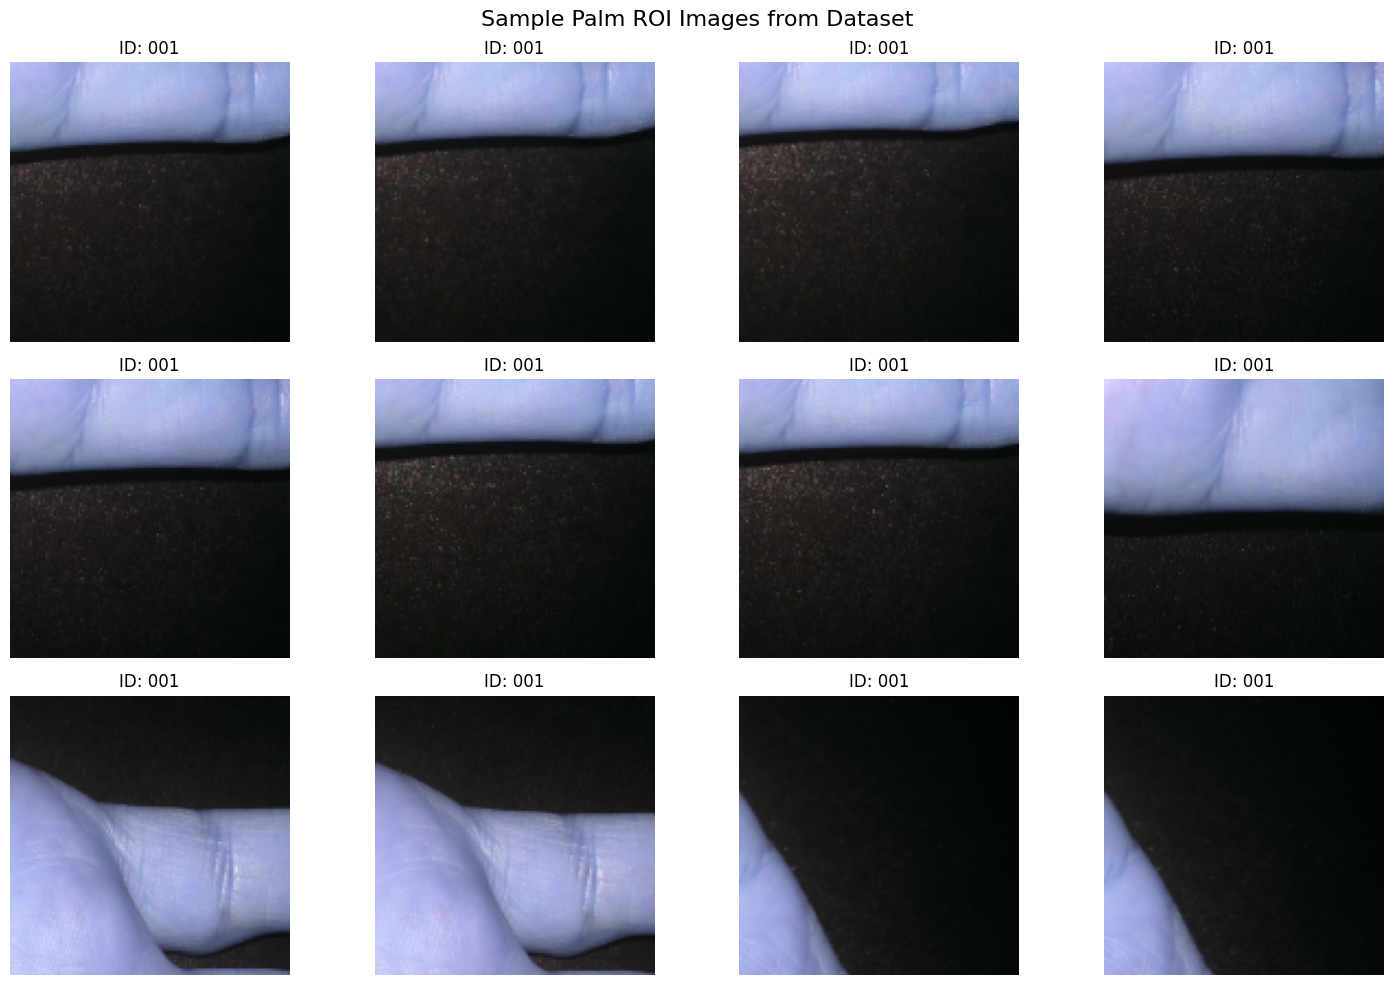


--- Class Distribution Analysis ---
Images per class - Min: 78, Max: 80, Mean: 79.9


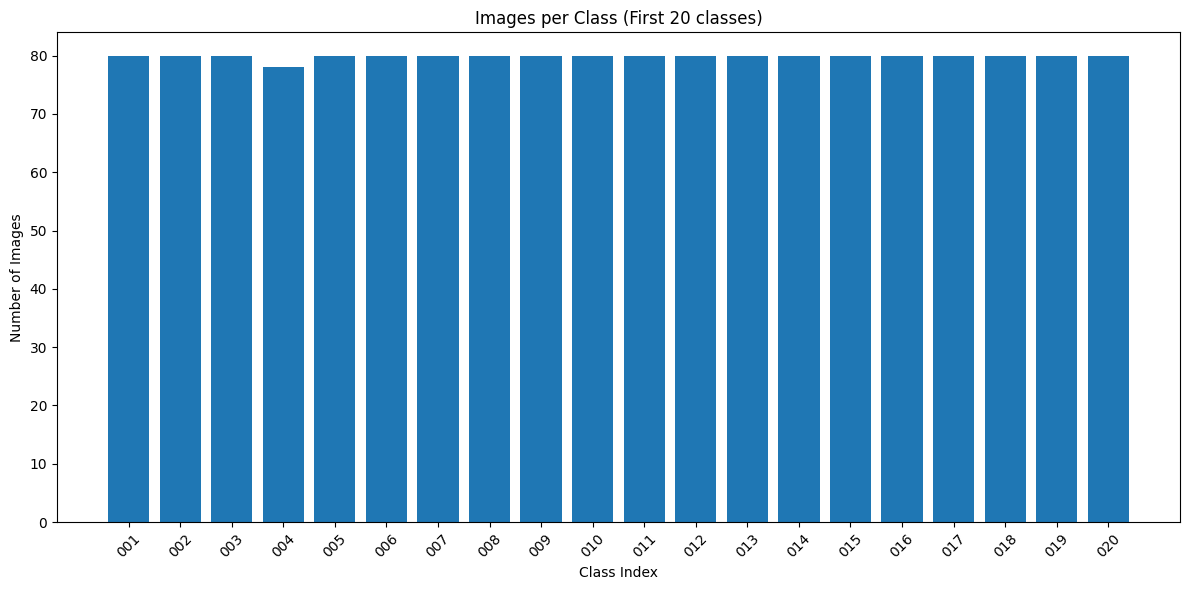

In [7]:
# Visualize sample processed images
print("--- Visualizing Sample Processed ROI Data ---")
plt.figure(figsize=(15, 10))

# Display first 12 images
for i in range(min(12, len(X))):
    ax = plt.subplot(3, 4, i + 1)
    
    # Convert to displayable format
    img = X[i].astype("uint8")
    plt.imshow(img)
    
    # Get class name from label
    label_idx = y[i]
    class_name = class_names[label_idx]
    plt.title(f"ID: {class_name}")
    plt.axis("off")

plt.suptitle("Sample Palm ROI Images from Dataset", fontsize=16)
plt.tight_layout()
plt.show()

# Show class distribution analysis
print("\n--- Class Distribution Analysis ---")
unique_labels, counts = np.unique(y, return_counts=True)
print(f"Images per class - Min: {counts.min()}, Max: {counts.max()}, Mean: {counts.mean():.1f}")

# Plot class distribution (for first 20 classes if there are many)
plt.figure(figsize=(12, 6))
classes_to_show = min(20, len(unique_labels))
plt.bar(range(classes_to_show), counts[:classes_to_show])
plt.title(f"Images per Class (First {classes_to_show} classes)")
plt.xlabel("Class Index")
plt.ylabel("Number of Images")
plt.xticks(range(classes_to_show), [class_names[i] for i in range(classes_to_show)], rotation=45)
plt.tight_layout()
plt.show()

## Train-Validation Split

In [8]:
# Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Dataset split:")
print(f"- Training samples: {len(X_train)}")
print(f"- Validation samples: {len(X_val)}")
print(f"- Training shape: {X_train.shape}")
print(f"- Validation shape: {X_val.shape}")

Dataset split:
- Training samples: 5883
- Validation samples: 1471
- Training shape: (5883, 128, 128, 3)
- Validation shape: (1471, 128, 128, 3)


## Create TensorFlow Datasets

In [9]:
# Create TensorFlow datasets with optimization
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(f"TensorFlow datasets created:")
print(f"- Training batches: {len(train_ds)}")
print(f"- Validation batches: {len(val_ds)}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Image size: {IMG_SIZE}")

TensorFlow datasets created:
- Training batches: 184
- Validation batches: 46
- Batch size: 32
- Image size: (128, 128)


## Data Augmentation Setup

--- Preview of Data Augmentation ---


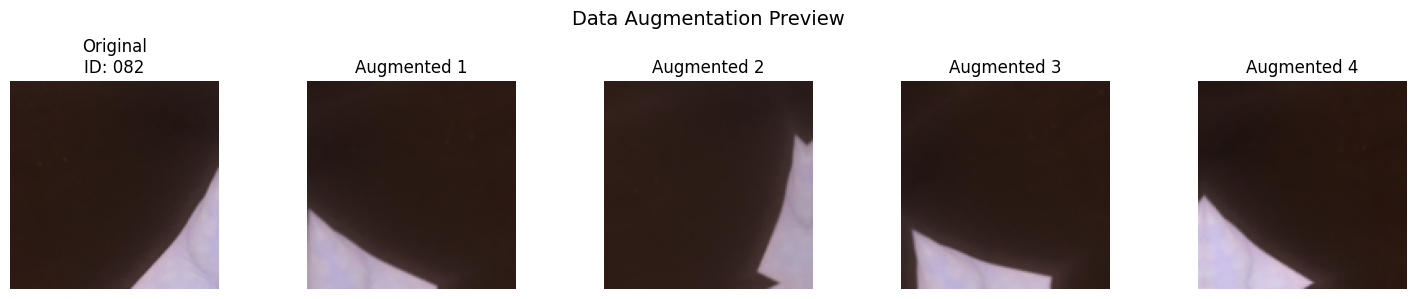

Data augmentation setup complete!


In [10]:
# Data augmentation layers for training
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
], name='augmentation')

print("--- Preview of Data Augmentation ---")

# Take one batch and show original vs augmented versions
for images, labels in train_ds.take(1):
    sample_image = images[0:1]  # Take first image
    sample_label = labels[0]
    
    plt.figure(figsize=(15, 3))
    
    # Original image
    plt.subplot(1, 5, 1)
    plt.imshow(sample_image[0].numpy().astype("uint8"))
    plt.title(f"Original\nID: {class_names[sample_label]}")
    plt.axis("off")
    
    # Show 4 augmented versions
    for i in range(4):
        augmented = data_augmentation(sample_image)
        plt.subplot(1, 5, i + 2)
        plt.imshow(augmented[0].numpy().astype("uint8"))
        plt.title(f"Augmented {i+1}")
        plt.axis("off")
    
    plt.suptitle("Data Augmentation Preview", fontsize=14)
    plt.tight_layout()
    plt.show()
    break

print("Data augmentation setup complete!")

## Build Base Model Architecture

In [11]:
# Build Model with Transfer Learning using MobileNetV2
print("--- Building Model using Transfer Learning (MobileNetV2) ---")
IMG_SHAPE = IMG_SIZE + (3,)

# Load pre-trained MobileNetV2 base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)
base_model._name = 'mobilenetv2_base'
base_model.trainable = False  # Freeze base model initially

print(f"Base model loaded: {base_model.name}")
print(f"Base model has {len(base_model.layers)} layers")
print(f"Input shape: {IMG_SHAPE}")
print("Base model is frozen for initial training")

--- Building Model using Transfer Learning (MobileNetV2) ---
Base model loaded: mobilenetv2_base
Base model has 154 layers
Input shape: (128, 128, 3)
Base model is frozen for initial training


In [12]:
# Build complete model architecture
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = layers.Rescaling(1./255)(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

print("Model architecture built successfully!")
print(f"Model will classify {len(class_names)} classes")
print(f"Final dense layer output: {len(class_names)} neurons")

Model architecture built successfully!
Model will classify 92 classes
Final dense layer output: 92 neurons


## Compile Model for Feature Extraction

In [13]:
# Compile Model for Feature Extraction
print("--- Compiling the Model ---")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_INITIAL),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Setup callbacks for training
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_palm_model.keras', 
        save_best_only=True, 
        monitor='val_accuracy', 
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=5, 
        monitor='val_loss', 
        restore_best_weights=True,
        verbose=1
    )
]

print("Model compiled and callbacks configured!")
print(f"Optimizer: Adam with learning rate {LEARNING_RATE_INITIAL}")
print("Loss function: sparse_categorical_crossentropy")
print("Metrics: accuracy")

--- Compiling the Model ---
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 augmentation (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 mobilenetv2_base (Functiona  (None, 4, 4, 1280)       2257984   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (Non

## Phase 1 Training - Feature Extraction

In [14]:
# Phase 1 Training - Feature Extraction
print("--- Starting Training Phase 1: Feature Extraction ---")
print("Base model is frozen, training only the classifier head...")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FEATURE_EXTRACTION,
    callbacks=callbacks,
    verbose=1
)

print("--- Phase 1 Training Complete ---")
print(f"Completed {len(history.history['accuracy'])} epochs")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

--- Starting Training Phase 1: Feature Extraction ---
Base model is frozen, training only the classifier head...
Epoch 1/10
184/184 [==============================] - ETA: 0s - loss: 4.0500 - accuracy: 0.1156
Epoch 1: val_accuracy improved from -inf to 0.34534, saving model to best_palm_model.keras
184/184 [==============================] - 91s 467ms/step - loss: 4.0500 - accuracy: 0.1156 - val_loss: 2.7419 - val_accuracy: 0.3453
Epoch 2/10
184/184 [==============================] - ETA: 0s - loss: 2.7726 - accuracy: 0.3310
Epoch 2: val_accuracy improved from 0.34534 to 0.49286, saving model to best_palm_model.keras
184/184 [==============================] - 84s 459ms/step - loss: 2.7726 - accuracy: 0.3310 - val_loss: 2.0884 - val_accuracy: 0.4929
Epoch 3/10
184/184 [==============================] - ETA: 0s - loss: 2.2479 - accuracy: 0.4472
Epoch 3: val_accuracy improved from 0.49286 to 0.57648, saving model to best_palm_model.keras
184/184 [==============================] - 93s 506ms

## Model Fine-tuning Setup

In [15]:
# Model Fine-tuning Setup
print("--- Preparing for Fine-Tuning ---")

# Unfreeze base model for fine-tuning
base_model = model.get_layer('mobilenetv2_base')
base_model.trainable = True

# Freeze early layers, only fine-tune top layers
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Fine-tuning from layer {fine_tune_at} onwards...")
print(f"Total layers in base model: {len(base_model.layers)}")
print(f"Trainable layers: {len([layer for layer in base_model.layers if layer.trainable])}")

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_FINE_TUNE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Model recompiled with learning rate: {LEARNING_RATE_FINE_TUNE}")
print("Ready for fine-tuning phase!")

--- Preparing for Fine-Tuning ---
Fine-tuning from layer 100 onwards...
Total layers in base model: 154
Trainable layers: 54
Model recompiled with learning rate: 1e-05
Ready for fine-tuning phase!


## Phase 2 Training - Fine Tuning

In [16]:
# Phase 2 Training - Fine Tuning
print("--- Starting Training Phase 2: Fine-Tuning ---")

# Continue training with fine-tuning
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FEATURE_EXTRACTION + EPOCHS_FINE_TUNE,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=callbacks,
    verbose=1
)

print("--- Phase 2 Fine-Tuning Complete ---")
print(f"Completed {len(history_fine.history['accuracy'])} additional epochs")
print(f"Final training accuracy: {history_fine.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history_fine.history['val_accuracy'][-1]:.4f}")

--- Starting Training Phase 2: Fine-Tuning ---
Epoch 11/15
184/184 [==============================] - ETA: 0s - loss: 0.9862 - accuracy: 0.7415
Epoch 11: val_accuracy improved from 0.75595 to 0.77294, saving model to best_palm_model.keras
184/184 [==============================] - 90s 459ms/step - loss: 0.9862 - accuracy: 0.7415 - val_loss: 0.9037 - val_accuracy: 0.7729
Epoch 12/15
184/184 [==============================] - ETA: 0s - loss: 0.8537 - accuracy: 0.7717
Epoch 12: val_accuracy did not improve from 0.77294
184/184 [==============================] - 90s 492ms/step - loss: 0.8537 - accuracy: 0.7717 - val_loss: 0.8767 - val_accuracy: 0.7729
Epoch 13/15
184/184 [==============================] - ETA: 0s - loss: 0.7928 - accuracy: 0.7872
Epoch 13: val_accuracy did not improve from 0.77294
184/184 [==============================] - 106s 575ms/step - loss: 0.7928 - accuracy: 0.7872 - val_loss: 0.8793 - val_accuracy: 0.7689
Epoch 14/15
184/184 [==============================] - ETA: 

## Model Evaluation and Results

In [17]:
# Model Evaluation and Results
print("--- Final Model Evaluation ---")

# Load best model
best_model = tf.keras.models.load_model('best_palm_model.keras')

# Evaluate on validation set
loss, accuracy = best_model.evaluate(val_ds, verbose=1)
print(f"\nFinal Model Performance:")
print(f"- Validation Loss: {loss:.4f}")
print(f"- Validation Accuracy: {accuracy * 100:.2f}%")
print(f"- Total classes: {len(class_names)}")
print(f"- Training samples: {len(X_train)}")
print(f"- Validation samples: {len(X_val)}")

--- Final Model Evaluation ---
46/46 [==============================] - 2s 15ms/step - loss: 0.7647 - accuracy: 0.8097

Final Model Performance:
- Validation Loss: 0.7647
- Validation Accuracy: 80.97%
- Total classes: 92
- Training samples: 5883
- Validation samples: 1471


## Training History Visualization

--- Plotting Training History ---


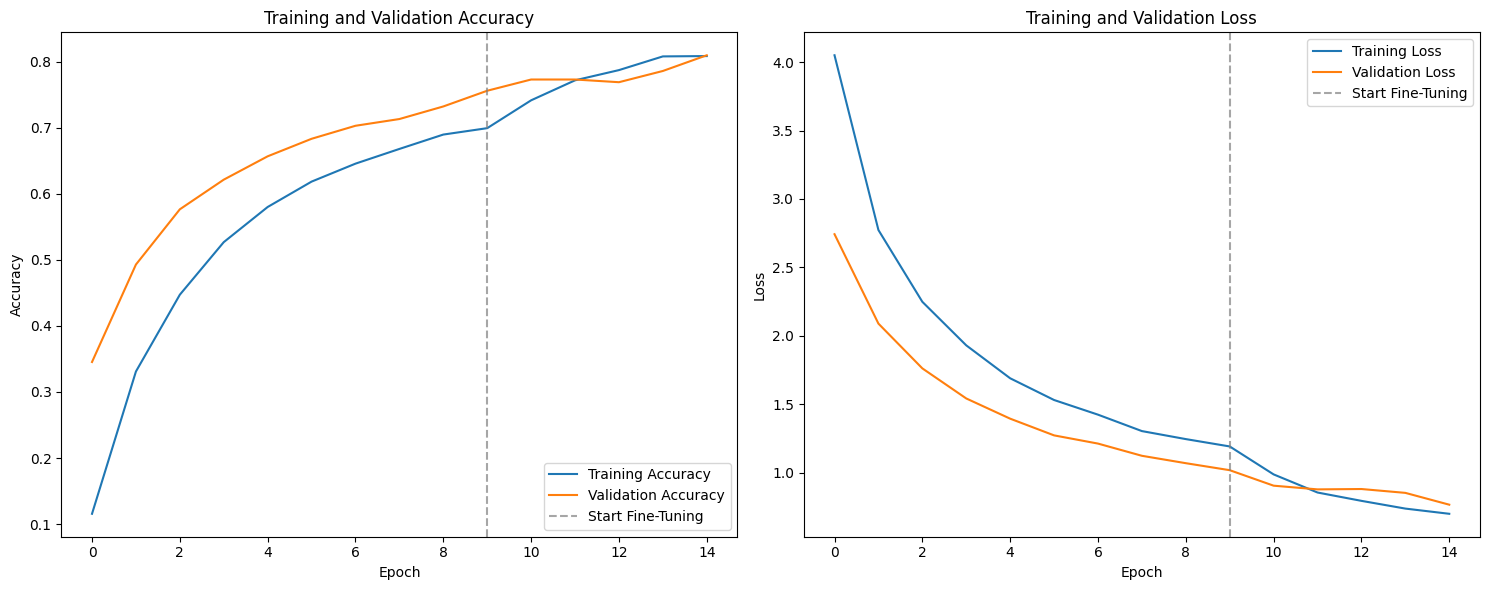

Training history visualization complete!
Plot saved to: 'training_history.png'


In [18]:
# Training History Visualization
print("--- Plotting Training History ---")

# Combine training histories from both phases
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.axvline(len(history.history['accuracy']) - 1, color='gray', linestyle='--', alpha=0.7, label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.axvline(len(history.history['loss']) - 1, color='gray', linestyle='--', alpha=0.7, label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history visualization complete!")
print("Plot saved to: 'training_history.png'")

## Save Final Model

In [19]:
# Save Final Model and Summary
print("--- Training Complete! ---")
print("\nModel and Results Summary:")
print(f"✓ Model saved to: 'best_palm_model.keras'")
print(f"✓ Training history plot saved to: 'training_history.png'")
print(f"✓ Total classes trained: {len(class_names)}")
print(f"✓ Total training images: {len(X_train)}")
print(f"✓ Total validation images: {len(X_val)}")
print(f"✓ Image size used: {IMG_SIZE}")
print(f"✓ Batch size: {BATCH_SIZE}")
print(f"✓ Feature extraction epochs: {EPOCHS_FEATURE_EXTRACTION}")
print(f"✓ Fine-tuning epochs: {EPOCHS_FINE_TUNE}")
print(f"✓ Final validation accuracy: {accuracy * 100:.2f}%")

print("\nModel is ready for inference!")
print("You can load the model using: tf.keras.models.load_model('best_palm_model.keras')")

--- Training Complete! ---

Model and Results Summary:
✓ Model saved to: 'best_palm_model.keras'
✓ Training history plot saved to: 'training_history.png'
✓ Total classes trained: 92
✓ Total training images: 5883
✓ Total validation images: 1471
✓ Image size used: (128, 128)
✓ Batch size: 32
✓ Feature extraction epochs: 10
✓ Fine-tuning epochs: 5
✓ Final validation accuracy: 80.97%

Model is ready for inference!
You can load the model using: tf.keras.models.load_model('best_palm_model.keras')


## Phase 3 : Prototype Demonstration & Testing

### Visualize testing dataset

In [ ]:
# Visualize the specific images enrolled for the new users
print("--- Visualizing Your Enrolled Palm Samples ---")

# --- CHANGE 1: Create a list of all user IDs you want to visualize ---
ENROLLED_USER_IDS = ['094', '095'] 

for user_id in ENROLLED_USER_IDS:
    user_dir = data_dir / user_id

    if not user_dir.exists():
        print(f"Error: Directory for user '{user_id}' not found.")
        continue # Skip to the next user in the list
    
    user_images = []
    for ext in image_extensions:
        user_images.extend(list(user_dir.glob(ext)))
    
    # Create a new figure for each user's plot
    plt.figure(figsize=(15, 10))
    
    # Display up to 12 sample images for the current user
    for i in range(min(12, len(user_images))):
        ax = plt.subplot(3, 4, i + 1)
        
        img = cv2.imread(str(user_images[i]))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        
        # --- CHANGE 3: Use the current user_id for the title ---
        plt.title(f"Palm (ID: {user_id})")
        plt.axis("off")

    plt.suptitle(f"Training Samples for Enrolled User '{user_id}'", fontsize=16)
    plt.tight_layout()
    plt.show()

### Demo

In [ ]:
import pathlib

print("--- Starting Prototype Demonstration ---")

# --- 1. Setup Test Environment ---
TEST_IMAGE_DIR = 'test_images'
CONFIDENCE_THRESHOLD = 0.90 

test_dir = pathlib.Path(TEST_IMAGE_DIR)

if not test_dir.exists():
    print(f"Error: Test directory '{TEST_IMAGE_DIR}' not found.")
else:
    # Use glob to find all images in the directory and its subdirectories
    image_extensions = ['*.jpg', '*.JPG', '*.png', '*.PNG', '*.jpeg', '*.JPEG']
    test_image_paths = []
    for ext in image_extensions:
        test_image_paths.extend(list(test_dir.glob(f'**/{ext}')))
    
    print(f"Found {len(test_image_paths)} images to test across all users.")

    # ### Visualize the test images before running inference ###
    print("\\n--- Displaying Images to be Tested ---")
    plt.figure(figsize=(16, 8))
    for i, path in enumerate(test_image_paths):
        ax = plt.subplot(2, 4, i + 1) # Assuming 8 images total (2 rows, 4 columns)
        img = cv2.imread(str(path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        # Get the user name from the parent folder
        user_name = path.parent.name
        plt.title(f"Test for: {user_name}")
        plt.axis('off')
    plt.suptitle("Held-out Test Images", fontsize=16)
    plt.tight_layout()
    plt.show()

    # --- 2. Load the Fully Trained Model and Class Names ---
    print("\\nLoading the best trained model: 'best_palm_model.keras'")
    final_model = tf.keras.models.load_model('best_palm_model.keras')
    print(f"Model is ready. It recognizes {len(class_names)} users.")

    # --- 3. Create Inference Function ---
    def run_inference_on_image(image_path, model, class_names_list):
        print(f"\\n--- Testing image: {image_path.name} from user {image_path.parent.name} ---")
        img = cv2.imread(str(image_path))
        roi = extract_palm_roi(img, size=IMG_SIZE)
        
        if roi is None:
            print("  Result: Could not detect a palm ROI in this image.")
            return

        img_array = np.expand_dims(roi, axis=0)
        predictions = model.predict(img_array, verbose=0)
        score = tf.nn.softmax(predictions[0])
        
        confidence = np.max(score)
        predicted_index = np.argmax(score)
        predicted_user = class_names_list[predicted_index]

        print(f"  Predicted User: '{predicted_user}'")
        print(f"  Confidence: {confidence:.2%}")

        if confidence > CONFIDENCE_THRESHOLD and predicted_user == image_path.parent.name:
            print("  Verification Status: CORRECT MATCH ✅")
            result_text = f"Verified: {predicted_user} ({confidence:.1%})"
            text_color = 'green'
        else:
            print("  Verification Status: INCORRECT MATCH ❌")
            result_text = f"Predicted {predicted_user} ({confidence:.1%})"
            text_color = 'red'

        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(result_text, color=text_color, fontsize=14)
        plt.axis('off')
        plt.show()

    # --- 4. Run Inference on All Test Images ---
    for path in test_image_paths:
        run_inference_on_image(path, final_model, class_names)